In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim

import numpy as np
import scipy as sp

In [2]:
from sklearn import datasets
from sklearn import model_selection as ms

from sklearn.metrics import confusion_matrix

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
data = datasets.load_digits().data
target = datasets.load_digits().target

In [6]:
data.shape

(1797, 64)

In [7]:
len(set(target))

10

In [9]:
tr_x,te_x,tr_y,te_y = ms.train_test_split(data,target,test_size=0.3, random_state = 123)

In [10]:
v_tr_x = Variable(torch.FloatTensor(tr_x.astype(float))).cuda()
v_tr_y = Variable(torch.from_numpy(tr_y)).cuda()
v_te_x = Variable(torch.FloatTensor(te_x.astype(float))).cuda()
v_te_y = Variable(torch.from_numpy(te_y)).cuda()

## default Network

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(64,100)
        self.l2 = nn.Linear(100,200)
        self.l3 = nn.Linear(200,100)
        self.l4 = nn.Linear(100,50)
        self.l5 = nn.Linear(50,10)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.dropout(F.leaky_relu(self.l3(x)), inplace=0.1)
        x = F.leaky_relu(self.l4(x))
        x = self.l5(x)
        return F.softmax(x),x

In [26]:
net = Net().cuda()

In [27]:
criteration = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [28]:
loss_list, score_list = [], []
for e in range(1,10001):
    optimizer.zero_grad()
    out,last_out = net(v_tr_x)
    loss = criteration(out, v_tr_y)
    loss.backward()
    optimizer.step()
    
    """ここからは途中の確認とログとり"""
    loss_list.append(loss.cpu().data.numpy()[0])
    pred,_= net(v_te_x)
    res = torch.exp(pred).cpu().data.numpy()
    score_list.append(sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y))
    if e%1000 == 0:
        #print()
        pred,_= net(v_te_x)
        res = torch.exp(pred).cpu().data.numpy()
        print("{0:5d} : {1} {2}".format(e,sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y),loss.cpu().data.numpy()[0]))

 1000 : 0.9722222222222222 1.4619531631469727
 2000 : 0.9740740740740741 1.4619474411010742
 3000 : 0.9777777777777777 1.4619463682174683
 4000 : 0.9777777777777777 1.4619462490081787
 5000 : 0.9777777777777777 1.4619461297988892
 6000 : 0.975925925925926 1.4619461297988892
 7000 : 0.9703703703703703 1.4611529111862183
 8000 : 0.9703703703703703 1.4611512422561646
 9000 : 0.9703703703703703 1.461150884628296
10000 : 0.9703703703703703 1.4611507654190063


In [29]:
pred,_= net(v_te_x)

In [30]:
res = torch.exp(pred).cpu().data.numpy()

In [31]:
confusion_matrix(te_y,np.argmax(res,axis=1))

array([[58,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 56,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 51,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 45,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 61,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 52,  0,  0,  0,  4],
       [ 0,  1,  0,  0,  0,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 44,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 51]])

In [32]:
sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j),len(te_y),sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y)

(524, 540, 0.9703703703703703)

In [33]:
pred,_= net(v_te_x)
res = torch.exp(pred).cpu().data.numpy()
sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y)

0.9703703703703703

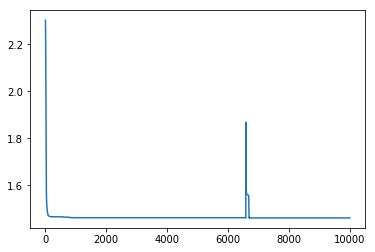

In [37]:
plt.plot(loss_list)

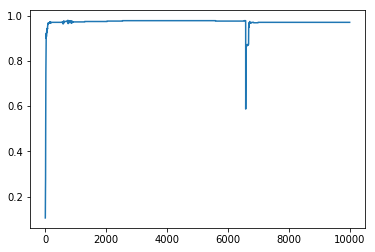

In [38]:
plt.plot(score_list)

## get soft_target(prob with temp_softmax)

In [12]:
def tmp_softmax(logit,T=1.0):
    tmp = logit / T
    over = torch.exp(tmp)
    under = torch.sum(torch.exp(tmp),1).view(-1,1)
    q = over / under
    return q

In [40]:
soft_target = tmp_softmax(last_out,T=4)

In [41]:
s_label = soft_target.cpu().data

In [42]:
soft_v_tr_y = Variable(s_label).cuda()

In [43]:
soft_v_tr_y

Variable containing:
 9.5945e-11  2.1271e-07  7.8560e-06  ...   5.0825e-08  2.8476e-06  1.3414e-05
 4.4898e-07  2.2617e-05  9.7412e-01  ...   3.7355e-06  5.6558e-05  4.4016e-05
 1.4103e-06  1.3363e-08  1.2585e-06  ...   2.9162e-05  1.4487e-06  2.9490e-05
                ...                   ⋱                   ...                
 2.0039e-04  4.2190e-05  1.2374e-05  ...   3.2652e-05  5.4501e-05  9.9871e-01
 2.7892e-04  4.8582e-05  5.1504e-04  ...   1.4525e-03  2.1731e-03  1.8087e-03
 5.5500e-04  1.1796e-05  2.0056e-06  ...   4.6183e-06  2.3090e-06  9.9920e-01
[torch.cuda.FloatTensor of size 1257x10 (GPU 0)]

In [44]:
torch.sum(soft_v_tr_y[0])

Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [45]:
out

Variable containing:
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  1.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  1.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  1.0000
[torch.cuda.FloatTensor of size 1257x10 (GPU 0)]

## simple net

In [46]:
class simple_Net(nn.Module):
    def __init__(self):
        super(simple_Net, self).__init__()
        self.l1 = nn.Linear(64,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,10)
        
    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return F.softmax(x),x

In [47]:
sim_net = simple_Net().cuda()

In [48]:
criteration = nn.CrossEntropyLoss()
loss1 = nn.CrossEntropyLoss()
loss2 = nn.CrossEntropyLoss()

optimizer = optim.Adam(sim_net.parameters(),lr=0.005)
#optimizer = optim.SGD(sim_net.parameters(),lr=0.01)

In [49]:
loss_list, score_list = [], []
for e in range(1,10001):
    optimizer.zero_grad()
    out,last_out = sim_net(v_tr_x)
    #loss = criteration(out, v_tr_y) + criteration(out,soft_target)
    #soft_loss = -torch.sum(v_tr_y.view(-1,1).float() * torch.log(soft_v_tr_y))
    #student_soft = tmp_softmax(last_out,T=4) 
    
    soft_loss = -torch.sum(soft_v_tr_y * torch.log(out))
    hard_loss = loss1(out,v_tr_y)#-torch.sum(v_tr_y.view(-1,1).float() * torch.log(out))
    loss = (hard_loss+soft_loss)/2
    
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.cpu().data.numpy()[0])
    pred,_= sim_net(v_te_x)
    res = torch.exp(pred).cpu().data.numpy()
    score_list.append(sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y))
    if e%1000 == 0:
        #print(lr)
        sim_pred,_= sim_net(v_te_x)
        #res = torch.exp(pred).
        sim_res=pred.cpu().data.numpy()
        #print(sum(1 for i,j in zip(te_y,np.argmax(sim_res,axis=1)) if i==j))
        print("{0:5d} : {1} {2}".format(e,sum(1 for i,j in zip(te_y,np.argmax(sim_res,axis=1)) if i==j)/len(te_y),loss.cpu().data.numpy()[0]))

 1000 : 0.9722222222222222 39.858245849609375
 2000 : 0.9722222222222222 39.22080612182617
 3000 : 0.9722222222222222 39.0859375
 4000 : 0.9722222222222222 39.02775573730469
 5000 : 0.9703703703703703 38.991905212402344
 6000 : 0.9703703703703703 38.97066879272461
 7000 : 0.9722222222222222 38.956363677978516
 8000 : 0.975925925925926 39.22239685058594
 9000 : 0.9740740740740741 39.04508590698242
10000 : 0.975925925925926 38.99543762207031


In [50]:
pred,_= sim_net(v_te_x)

In [51]:
res = pred.cpu().data.numpy()

In [52]:
confusion_matrix(v_te_y.cpu().data.numpy(),np.argmax(res,axis=1))

array([[59,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 56,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 51,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 45,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 61,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 52,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0, 57,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 45,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2, 51]])

In [53]:
sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j),len(te_y),sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y)

(527, 540, 0.975925925925926)

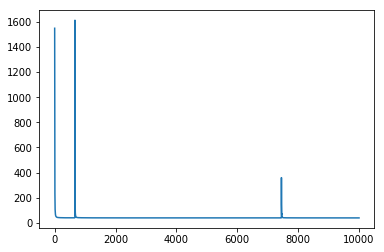

In [54]:
plt.plot(loss_list)

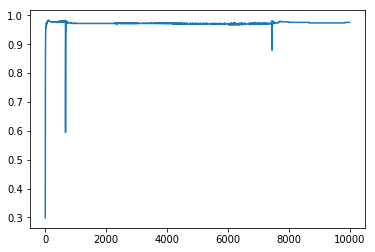

In [55]:
plt.plot(score_list)

In [ ]:
loss_list, score_list = [], []
loss_list.append(loss.cpu().data.numpy()[0])
pred,_= sim_net(v_te_x)
res = torch.exp(pred).cpu().data.numpy()
score_list.append(sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y))

# MNISTで蒸留をやってみる

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("../DNN_prac/challenge_MNIST/train.csv")

In [6]:
label = df["label"].as_matrix()

In [7]:
data = df.drop("label",axis=1).as_matrix()

In [8]:
data.shape

(42000, 784)

In [9]:
tr_d,te_x,tr_l,te_y = ms.train_test_split(data.reshape(data.shape[0],1,28,28),label,test_size=0.2,random_state=123)

In [10]:
tr_d.shape

(33600, 1, 28, 28)

In [11]:
tr_x,vali_x,tr_y,vali_y = ms.train_test_split(tr_d,tr_l,test_size=0.2,random_state=124)

In [14]:
v_tr_x = Variable(torch.FloatTensor(tr_x.astype(float))).cuda()
v_tr_y = Variable(torch.from_numpy(tr_y)).cuda()
v_vali_x = Variable(torch.FloatTensor(vali_x.astype(float))).cuda()
v_vali_y = Variable(torch.from_numpy(vali_y)).cuda()

v_te_x = Variable(torch.FloatTensor(te_x.astype(float))).cuda()
v_te_y = Variable(torch.from_numpy(te_y)).cuda()


In [15]:
v_te_x.size()

torch.Size([8400, 1, 28, 28])

In [16]:
def calc_outsize(x,p=0,k=2,s=1):
    return (x + p - k)//s + 1
x=28
pool = lambda x,p: x//p
x = calc_outsize(x,p=0,k=2,s=1)
x = pool(x,2)
print(x)
x = calc_outsize(x,p=0,k=2,s=1)
x = pool(x,2)
print(x)
x = calc_outsize(x,p=0,k=2,s=1)
#x = pool(x,2)
print(x)
x = calc_outsize(x,p=0,k=2,s=1)
#x = pool(x,2)
print(x)
x = calc_outsize(x,p=0,k=2,s=1)
x = pool(x,2)
print(x)

13
6
5
4
1


# Create teacher model

In [60]:
class Cnn(nn.Module):
    
    def __init__(self):
        super(Cnn,self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=40, kernel_size=2, stride=1)
        self.conv4 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=2, stride=1)
        self.conv5 = nn.Conv2d(in_channels=80, out_channels=160*2*2, kernel_size=2, stride=1)
        
        self.fc1 = nn.Linear(in_features=160*2*2, out_features=320)
        self.fc2 = nn.Linear(in_features=320, out_features=160)
        self.fc3 = nn.Linear(in_features=160, out_features=10)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.dropout(F.relu(self.conv4(x)),inplace=0.2)
        
        x = self.pool(F.relu(self.conv5(x)))
        #print(x.size())
        x = x.view(-1,160*2*2)
        #print(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x), x

In [61]:
cnn = Cnn().cuda()

## train teacher model

In [62]:
criteration = nn.CrossEntropyLoss()
#optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

v_tr_x.size(0)/60

In [63]:
%%time
l = 60
loss_list, score_list = [], []

for e in range(1,101):
    lr = []
    for i in range(448):
        in_data, in_label = v_tr_x[(0+i)*l:(1+i)*l], v_tr_y[(0+i)*l:(1+i)*l]
        
        optimizer.zero_grad()
        out,last_out = cnn(in_data)
        loss = criteration(out, in_label)
        loss.backward()
        
        optimizer.step()
        

        
        lr += [loss.data.mean()]
        
    loss_list.append(loss.cpu().data.numpy()[0])
    pred,_= cnn(v_te_x)
    res = torch.exp(pred).cpu().data.numpy()
    score_list.append(sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y))
    
    if e%2 == 0:
        pred,_ = cnn(v_vali_x)
        res = pred.max(1)[1].cpu().data.numpy()
        print("{0:2d} : {1:4d} : {2}, {3}, {4}, {5}".format(e,i,np.mean(lr),\
                sum(1 for i,j in zip(vali_y,res) if i==j),len(vali_y),sum(1 for i,j in zip(vali_y,res) if i==j)/len(vali_y)))

 2 :  447 : 0.2534682814896639, 6342, 6720, 0.94375
 4 :  447 : 0.12095804258258015, 6429, 6720, 0.9566964285714286
 6 :  447 : 0.07770124898213128, 6460, 6720, 0.9613095238095238
 8 :  447 : 0.047572290178452804, 6473, 6720, 0.9632440476190476
10 :  447 : 0.03592048806162244, 6397, 6720, 0.9519345238095238
12 :  447 : 0.10012746593734587, 6355, 6720, 0.9456845238095238
14 :  447 : 0.024668964409881613, 6505, 6720, 0.9680059523809523
16 :  447 : 0.0724349440446466, 6209, 6720, 0.9239583333333333
18 :  447 : 0.013431484223344472, 6533, 6720, 0.9721726190476191
20 :  447 : 0.006046205543790555, 6560, 6720, 0.9761904761904762
22 :  447 : 0.007479733074624002, 6554, 6720, 0.975297619047619
24 :  447 : 0.002295850148048625, 6588, 6720, 0.9803571428571428
26 :  447 : 0.000558250352355064, 6588, 6720, 0.9803571428571428
28 :  447 : 0.00031612668500916437, 6589, 6720, 0.9805059523809524
30 :  447 : 0.0002234887428052953, 6590, 6720, 0.9806547619047619
32 :  447 : 0.0001646206620285235, 6592, 6

In [64]:
pred,_ = cnn(v_vali_x)

In [65]:
res = pred.max(1)[1].cpu().data.numpy()

In [66]:
res

array([1, 9, 5, ..., 8, 9, 2])

In [67]:
confusion_matrix(vali_y,res)

array([[657,   1,   0,   0,   2,   2,   1,   1,   0,   1],
       [  1, 772,   1,   0,   0,   0,   0,   1,   1,   0],
       [  0,   1, 627,   3,   2,   0,   0,   4,   4,   0],
       [  1,   0,   6, 657,   0,   9,   0,   1,   3,   1],
       [  1,   1,   3,   0, 658,   0,   1,   2,   1,   5],
       [  1,   0,   0,   2,   0, 593,   1,   0,   3,   0],
       [  2,   0,   1,   0,   0,   1, 663,   0,   4,   0],
       [  0,   1,   4,   2,   0,   1,   0, 667,   2,   4],
       [  3,   3,   1,   3,   2,   0,   1,   2, 612,   3],
       [  4,   0,   0,   0,   6,   4,   0,   6,   5, 681]])

In [68]:
sum(1 for i,j in zip(vali_y,res) if i==j),len(vali_y),sum(1 for i,j in zip(vali_y,res) if i==j)/len(vali_y)

(6587, 6720, 0.9802083333333333)

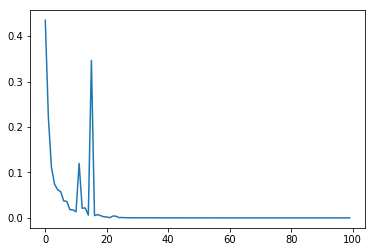

In [69]:
plt.plot(loss_list)

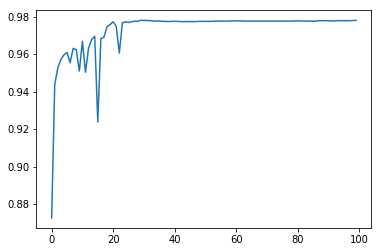

In [70]:
plt.plot(score_list)

# test_dataでの検証

In [71]:
pred,_ = cnn(v_te_x)
res = pred.max(1)[1].cpu().data.numpy()
print(confusion_matrix(te_y,res))
sum(1 for i,j in zip(te_y,res) if i==j),len(te_y),sum(1 for i,j in zip(te_y,res) if i==j)/len(te_y)

[[779   0   2   0   0   0   2   0   0   2]
 [  0 934   5   2   1   0   0   1   6   0]
 [  0   1 820   3   0   1   0   5   5   3]
 [  0   0   6 838   0   4   0   2   7   1]
 [  0   2   1   0 780   1   2   2   2   6]
 [  1   1   1   6   2 780   4   0   4   1]
 [  1   1   0   0   1   2 865   0   0   0]
 [  1   1   9   4   3   0   0 832   4   6]
 [  1   4   1   3   2   5   2   1 790   8]
 [  4   0   1   3   9   7   0   3   3 797]]


(8215, 8400, 0.9779761904761904)

# 学習を終えた教師モデルからlogitを獲得
# logitをtemp_softmaxに流し，温度付きの確率ラベルを獲得

### Get a logit from a teacher model that has finished learning.
### The prob label is obtained using the temp_softmax function with logit.

In [72]:
_,last_out = cnn(v_tr_x)

In [73]:
soft_target = tmp_softmax(last_out,T=3)

In [74]:
s_label = soft_target.cpu().data

In [75]:
soft_v_tr_y = Variable(s_label).cuda()

In [76]:
def calc_outsize(x,p=0,k=2,s=1):
    return (x + p - k)//s + 1
x=28
pool = lambda x,p: x//p
x = calc_outsize(x,p=0,k=5,s=1)
x = pool(x,2)
print(x)
x = calc_outsize(x,p=0,k=4,s=1)
x = pool(x,2)
print(x)
x = calc_outsize(x,p=0,k=2,s=1)
#x = pool(x,2)
# print(x)
# x = calc_outsize(x,p=0,k=2,s=1)
# #x = pool(x,2)
# print(x)
# x = calc_outsize(x,p=0,k=2,s=1)
x = pool(x,2)
print(x)

12
4
1


## simple cnn

In [77]:
class simple_CNN(nn.Module):
    def __init__(self):
        super(simple_CNN,self).__init__()
        self.pool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40*2*2, kernel_size=2, stride=1)
        
        self.fc1 = nn.Linear(in_features=40*2*2,out_features=80)
        self.fc2 = nn.Linear(in_features=80,out_features=10)
                
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        
        x = x.view(-1,40*2*2)
        
        x = F.dropout(F.leaky_relu(self.fc1(x)),inplace=0.3)
        x = self.fc2(x)
        return F.softmax(x), x

In [78]:
sim_cnn = simple_CNN().cuda()

In [79]:
criteration = nn.CrossEntropyLoss()
loss1 = nn.CrossEntropyLoss()
#optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer = optim.Adam(sim_cnn.parameters(), lr=0.0001)

In [80]:
%%time
l = 60
loss_list, score_list = [], []
for e in range(1,101):
    lr = []
    for i in range(448):
        in_data, in_label = v_tr_x[(0+i)*l:(1+i)*l], v_tr_y[(0+i)*l:(1+i)*l]
        #print(in_data.size())
        optimizer.zero_grad()
        out,_ = sim_cnn(in_data)
        #_,soft_out = cnn(in_data)
        #soft_loss = -torch.sum(soft_out * torch.log1p(out))
        soft_loss = -torch.sum(soft_v_tr_y[(0+i)*l:(1+i)*l] * torch.log(out))
        hard_loss = loss1(out,in_label)#-torch.sum(v_tr_y.view(-1,1).float() * torch.log(out))
        loss = (hard_loss+soft_loss)/2
        
        #loss = criteration(out, in_label)
        loss.backward()
        
        optimizer.step()
        
        lr += [loss.data.mean()]
    loss_list.append(loss.cpu().data.numpy()[0])
    pred,_= sim_cnn(v_te_x)
    res = torch.exp(pred).cpu().data.numpy()
    score_list.append(sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y))
    if e%2 == 0:
        pred,_ = sim_cnn(v_vali_x)
        res = pred.max(1)[1].cpu().data.numpy()
        print("{0:2d} : {1:4d} : {2}, {3}, {4}, {5}".format(e,i,np.mean(lr),\
                sum(1 for i,j in zip(vali_y,res) if i==j),len(vali_y),sum(1 for i,j in zip(vali_y,res) if i==j)/len(vali_y)))

 2 :  447 : 11.510589554373707, 6092, 6720, 0.906547619047619
 4 :  447 : 7.122229093685746, 6302, 6720, 0.937797619047619
 6 :  447 : 5.710872805012124, 6370, 6720, 0.9479166666666666
 8 :  447 : 4.8841389407004625, 6419, 6720, 0.9552083333333333
10 :  447 : 4.318345305376819, 6445, 6720, 0.9590773809523809
12 :  447 : 3.904970720410347, 6457, 6720, 0.9608630952380952
14 :  447 : 3.584715093885149, 6467, 6720, 0.9623511904761904
16 :  447 : 3.3269152117094825, 6472, 6720, 0.9630952380952381
18 :  447 : 3.0930785313248634, 6485, 6720, 0.9650297619047619
20 :  447 : 2.8977319302835634, 6494, 6720, 0.9663690476190476
22 :  447 : 2.731431002329503, 6497, 6720, 0.9668154761904761
24 :  447 : 2.5935219999934946, 6494, 6720, 0.9663690476190476
26 :  447 : 2.483830044844321, 6491, 6720, 0.965922619047619
28 :  447 : 2.383506679907441, 6486, 6720, 0.9651785714285714
30 :  447 : 2.304387671074697, 6485, 6720, 0.9650297619047619
32 :  447 : 2.2372071503528526, 6475, 6720, 0.9635416666666666
34 :

# evaluate test_data

In [81]:
pred,_ = sim_cnn(v_te_x)
res = pred.max(1)[1].cpu().data.numpy()
print(confusion_matrix(te_y,res))
sum(1 for i,j in zip(te_y,res) if i==j),len(te_y),sum(1 for i,j in zip(te_y,res) if i==j)/len(te_y)

[[766   0   1   0   1   6   7   2   0   2]
 [  0 943   3   1   0   0   0   1   1   0]
 [  0   2 818   5   1   0   0   7   5   0]
 [  0   0   6 839   0   4   0   4   5   0]
 [  0   3   1   0 784   0   2   0   3   3]
 [  1   2   1   3   1 778   3   1   9   1]
 [  2   2   2   0   2   4 857   0   1   0]
 [  0   1  16   3   2   0   0 834   1   3]
 [  0   4   1   0   1   5   0   1 802   3]
 [  5   1   0   1  15   6   0  10   7 782]]


(8203, 8400, 0.976547619047619)

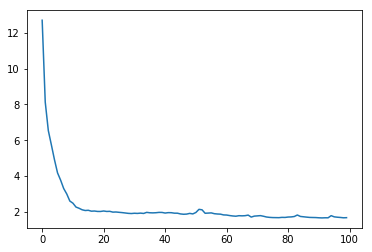

In [82]:
plt.plot(loss_list)

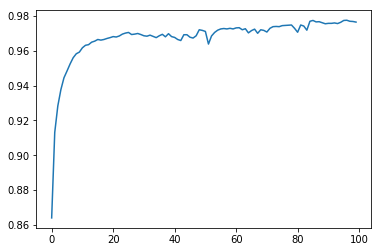

In [83]:
plt.plot(score_list)

# 蒸留無し
### without distillation

In [88]:
class simple_CNN(nn.Module):
    def __init__(self):
        super(simple_CNN,self).__init__()
        self.pool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40*2*2, kernel_size=2, stride=1)
        
        self.fc1 = nn.Linear(in_features=40*2*2,out_features=80)
        self.fc2 = nn.Linear(in_features=80,out_features=10)
                
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        
        x = x.view(-1,40*2*2)
        
        x = F.dropout(F.leaky_relu(self.fc1(x)),inplace=0.3)
        x = self.fc2(x)
        return F.softmax(x), x
sim_cnn = simple_CNN().cuda()
criteration = nn.CrossEntropyLoss()
optimizer = optim.Adam(sim_cnn.parameters(), lr=0.0001)
l = 60

loss_list, socre_list = [], []
for e in range(1,101):
    lr = []
    for i in range(448):
        in_data, in_label = v_tr_x[(0+i)*l:(1+i)*l], v_tr_y[(0+i)*l:(1+i)*l]
        #print(in_data.size())
        optimizer.zero_grad()
        out,_ = sim_cnn(in_data)
        loss = criteration(out, in_label)
        loss.backward()
        
        optimizer.step()
        
        lr += [loss.data.mean()]
        
    loss_list.append(loss.cpu().data.numpy()[0])
    pred,_= sim_cnn(v_te_x)
    res = torch.exp(pred).cpu().data.numpy()
    score_list.append(sum(1 for i,j in zip(te_y,np.argmax(res,axis=1)) if i==j)/len(te_y))
    if e%2 == 0:
        pred,_ = sim_cnn(v_vali_x)
        res = pred.max(1)[1].cpu().data.numpy()
        print("{0:2d} : {1:4d} : {2}, {3}, {4}, {5}".format(e,i,np.mean(lr),\
                sum(1 for i,j in zip(vali_y,res) if i==j),len(vali_y),sum(1 for i,j in zip(vali_y,res) if i==j)/len(vali_y)))

 2 :  447 : 1.7545084894767828, 4924, 6720, 0.7327380952380952
 4 :  447 : 1.7083871361932583, 5076, 6720, 0.7553571428571428
 6 :  447 : 1.6966390434120382, 5142, 6720, 0.7651785714285714
 8 :  447 : 1.6899362384740795, 5173, 6720, 0.7697916666666667
10 :  447 : 1.659784131018179, 5725, 6720, 0.8519345238095238
12 :  447 : 1.5976560711860657, 5819, 6720, 0.865922619047619
14 :  447 : 1.5906002351215907, 5844, 6720, 0.8696428571428572
16 :  447 : 1.5872163203145777, 5842, 6720, 0.8693452380952381
18 :  447 : 1.5846699287316628, 5838, 6720, 0.86875
20 :  447 : 1.5824364426412754, 5846, 6720, 0.8699404761904762
22 :  447 : 1.580899961824928, 5855, 6720, 0.8712797619047619
24 :  447 : 1.5797694304159708, 5846, 6720, 0.8699404761904762
26 :  447 : 1.5796336497047119, 5858, 6720, 0.8717261904761905
28 :  447 : 1.5778217964938708, 5848, 6720, 0.8702380952380953
30 :  447 : 1.5776055359414645, 5866, 6720, 0.8729166666666667
32 :  447 : 1.5766221625464303, 5874, 6720, 0.8741071428571429
34 :  

In [89]:
pred,_ = sim_cnn(v_te_x)
res = pred.max(1)[1].cpu().data.numpy()
print(confusion_matrix(te_y,res))
sum(1 for i,j in zip(te_y,res) if i==j),len(te_y),sum(1 for i,j in zip(te_y,res) if i==j)/len(te_y)

[[775   0   0   0   0   0   8   0   1   1]
 [  0 940   4   1   0   0   1   3   0   0]
 [  5   1 802   9   2   2   4  11   1   1]
 [  0   0   2 837   0   2   0   7   5   5]
 [  0   0   0   0 780   0   4   2   3   7]
 [  4   0   0   5   3 775   5   1   3   4]
 [  2   0   0   0   3   1 864   0   0   0]
 [  4   1   7   2   2   1   0 840   1   2]
 [  1   2   2   0   7   5   4   4 785   7]
 [  3   0   0   1   7   3   1   6   6 800]]


(8198, 8400, 0.9759523809523809)

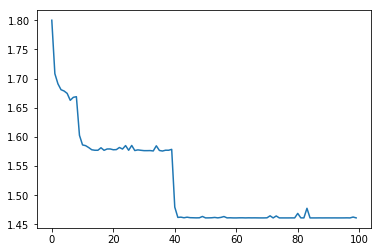

In [90]:
plt.plot(loss_list)

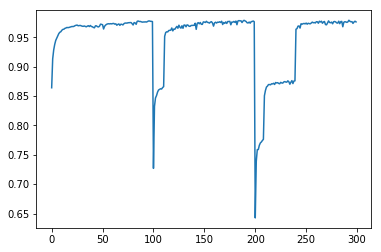

In [91]:
plt.plot(score_list)

## 蒸留を行わない場合だと収束に揺れや段差が出る